In [26]:
import warnings
warnings.filterwarnings("ignore")

In [1]:
import re
import pandas as pd

train_dataset = pd.read_csv('./Corona_NLP_train.csv', encoding = "ISO-8859-1")
test_dataset = pd.read_csv('./Corona_NLP_test.csv', encoding = "ISO-8859-1")

to_drop = ['UserName', 'ScreenName', 'Location', 'TweetAt']

train_dataset = train_dataset.drop(columns=to_drop).sample(frac=1, random_state=42) # shuffle rows
test_dataset = test_dataset.drop(columns=to_drop)

def clean_text(text):
    text = text.lower()
    hashtags = "#[\S]+"
    mentions = "@[\S]+"
    url = "https?://[A-z0-9_%/\-\.]+[A-z0-9_\.\-\?&=%]+"
    text = re.sub(url,"",text)
    text = re.sub(hashtags,"",text)
    text = re.sub(mentions,"",text)
    puntuations = "[\.\?!,;:]+"
    text = re.sub(puntuations,"",text)
    return text

map = {
    'Extremely Negative': 0,
    'Negative': 1,
    'Neutral': 2,
    'Positive': 3,
    'Extremely Positive': 4
}

revmap = {
    0: 'Extremely Negative',
    1: 'Negative',
    2: 'Neutral',
    3: 'Positive',
    4: 'Extremely Positive'
}

train_dataset['OriginalTweet'] = train_dataset['OriginalTweet'].apply(lambda x: clean_text(x))
test_dataset['OriginalTweet'] = test_dataset['OriginalTweet'].apply(lambda x: clean_text(x))

train_dataset['Sentiment'] = train_dataset['Sentiment'].apply(lambda x: map[x])
test_dataset['Sentiment'] = test_dataset['Sentiment'].apply(lambda x: map[x])

,OriginalTweet,Sentiment
31089,without the there would not be any problem wh...,Neutral
35564,rice &amp wheat prices surge amid fears covid-...,Extremely Negative
144,when the government says to start social dista...,Positive
8202,what the shops are doing is obeying the law of...,Positive
31720,kaduna state task force on covid 19 led by the...,Negative
...,...,...
6265,minnesota classifies grocery store workers as ...,Negative
11284,us senator has asked for information about a...,Negative
38158,just commented on poll are you doing more onl...,Extremely Negative
860,my wife got laid off yesterday because the sma...,Neutral


In [6]:
import torch
from torch import nn
from prettytable import PrettyTable
from transformers import AutoModel, AutoTokenizer
from modules import Encoder, EncoderForSequenceClassification

def count_parameters(model):
    table = PrettyTable(["Modules", "Parameters"])
    total_params = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad: continue
        params = parameter.numel()
        table.add_row([name, params])
        total_params+=params
    print(table)
    print(f"Total Trainable Params: {total_params}")
    return total_params

model_name = 'prajjwal1/bert-tiny'
tokenizer = AutoTokenizer.from_pretrained(model_name)
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

c:\Users\dlaptev\AppData\Local\Programs\Python\Python311\Lib\site-packages\transformers\utils\generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


In [17]:
from torch.utils.data import DataLoader, Dataset
from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder(sparse=False)

class TwitterDataset(Dataset):
    def __init__(self, set) -> None:
        super(TwitterDataset, self).__init__()
        self.input = set['input_ids']
        self.labels = set['labels']
    
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, index):
        return {
        'input_ids': self.input[index],
        'labels': self.labels[index]
    }

def dset(set):
    tweets = set['OriginalTweet'].to_list()
    tokenized = tokenizer(tweets, return_tensors='pt', padding='max_length', truncation=True, max_length=256)

    return {
        'input_ids': tokenized['input_ids'],
        'labels': ohe.fit_transform(set['Sentiment'].to_numpy().reshape(-1, 1))
    }

train_loader = DataLoader(TwitterDataset(dset(train_dataset)), batch_size=256)
test_loader = DataLoader(TwitterDataset(dset(test_dataset)), batch_size=128)

c:\Users\dlaptev\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
c:\Users\dlaptev\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


---
## Тренировка модели

In [39]:
import torch
import numpy as np
from tqdm.notebook import tqdm_notebook as tqdm
import matplotlib.pyplot as plt
from torch.optim import Adam, AdamW, lr_scheduler
from sklearn.metrics import classification_report

def train(model, loader, epochs, lr):
    optimizer = Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()
    # scheduler = lr_scheduler.OneCycleLR(
    #     optimizer=optimizer, 
    #     total_steps=len(loader)*epochs,
    #     max_lr=lr
    #     )

    model.train()
    
    losses = []
    pbar, step = tqdm(range(len(loader) * epochs)), 0
 
    for epoch in range(epochs):
        for batch in loader:
            inputs = batch['input_ids'].to(device)
            labels = batch['labels'].to(device)
            preds = model(inputs)
            loss = criterion(preds, labels)
            
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            
            losses.append(loss.item())
            pbar.set_description(f'Epoch: {epoch+1}, training loss: {loss.item():0.5f}')#, lr: {scheduler.get_last_lr()[0]:0.5f}')

            step +=1
            pbar.update(1)
        # scheduler.step()

    return losses

def evaluate(model, set):
    pred, true = [], []

    model.eval()
    with torch.no_grad():
        for batch in tqdm(set):
            inputs = batch['input_ids'].to(device)
            labels = batch['labels'].to(device)
            preds = model(inputs)
            pred.extend(torch.argmax(preds.cpu(), dim=-1))
            true.extend(torch.argmax(labels.cpu(), dim=-1))
    pred = np.array(pred)
    true = np.array(true)

    return true, pred

In [37]:
classifier = EncoderForSequenceClassification(
    Encoder(tokenizer.vocab_size, 
            num_layers=2,
            attn_heads=4,
            hidden_dim=64,
            dropout=0.2,
            context=256),
    num_classes = 5
)
count_parameters(classifier)

+-----------------------------------+------------+
|              Modules              | Parameters |
+-----------------------------------+------------+
|         encoder.te.weight         |  1953408   |
|   encoder.layers.0.attention.wqs  |    4096    |
|   encoder.layers.0.attention.wks  |    4096    |
|   encoder.layers.0.attention.wvs  |    4096    |
|   encoder.layers.0.attention.wo   |    4096    |
|   encoder.layers.0.linear.weight  |    4096    |
|    encoder.layers.0.linear.bias   |     64     |
| encoder.layers.0.layernorm.weight |     64     |
|  encoder.layers.0.layernorm.bias  |     64     |
|   encoder.layers.1.attention.wqs  |    4096    |
|   encoder.layers.1.attention.wks  |    4096    |
|   encoder.layers.1.attention.wvs  |    4096    |
|   encoder.layers.1.attention.wo   |    4096    |
|   encoder.layers.1.linear.weight  |    4096    |
|    encoder.layers.1.linear.bias   |     64     |
| encoder.layers.1.layernorm.weight |     64     |
|  encoder.layers.1.layernorm.b

1995077

In [40]:
true, pred = evaluate(classifier, test_loader)
print(classification_report(true, pred))

  0%|          | 0/30 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.17      0.20      0.18       592
           1       0.23      0.12      0.15      1041
           2       0.16      0.32      0.21       619
           3       0.24      0.12      0.16       947
           4       0.16      0.23      0.19       599

    accuracy                           0.18      3798
   macro avg       0.19      0.20      0.18      3798
weighted avg       0.20      0.18      0.17      3798



In [41]:
losses = train(classifier, train_loader, epochs=10, lr=1e-2)

  0%|          | 0/1610 [00:00<?, ?it/s]

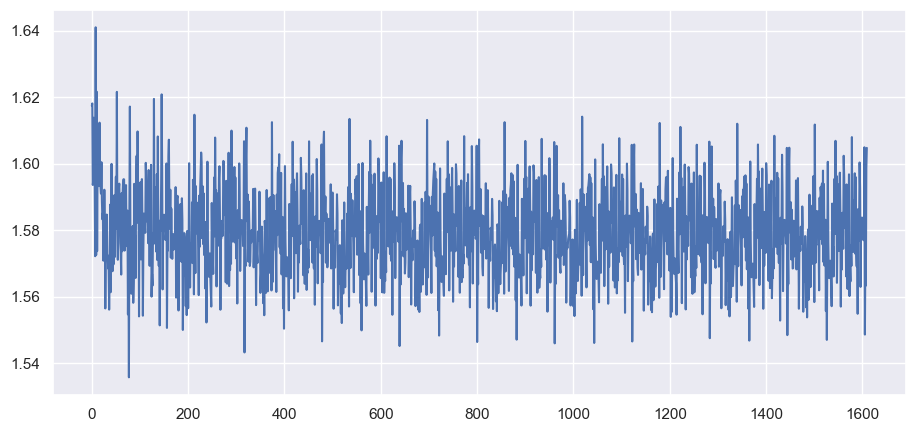

In [42]:
plt.plot(torch.arange(len(losses)), losses)
plt.show()

In [43]:
true, pred = evaluate(classifier, test_loader)
print(classification_report(true, pred))

  0%|          | 0/30 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       592
           1       0.00      0.00      0.00      1041
           2       0.00      0.00      0.00       619
           3       0.25      1.00      0.40       947
           4       0.00      0.00      0.00       599

    accuracy                           0.25      3798
   macro avg       0.05      0.20      0.08      3798
weighted avg       0.06      0.25      0.10      3798



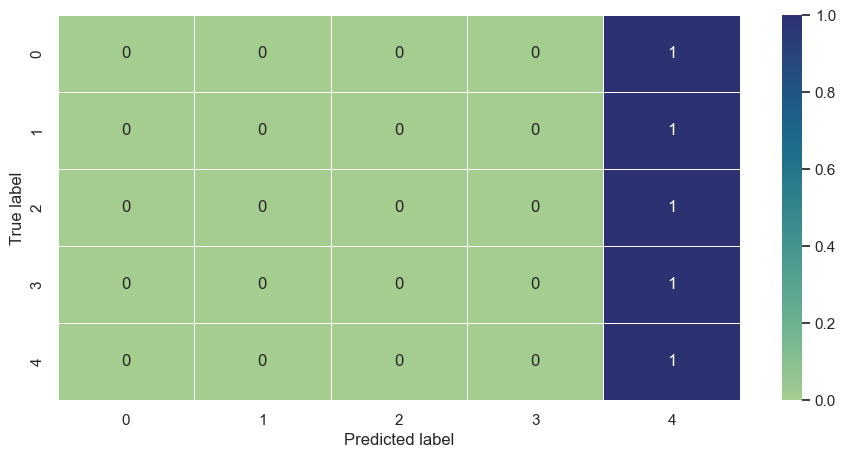

In [44]:
from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix([revmap[x] for x in true], [revmap[x] for x in pred])
conf_mat_normalized = conf_mat.astype('float') / conf_mat.sum(axis=1)[:, np.newaxis]
sns.heatmap(conf_mat_normalized, annot=True, linewidth=.5, cmap="crest")
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()